# 1D Umbrella Sampling and WHAM
MENG 25500 project by Henry Bloom and Arnav Brahmasandra.

Check out our [writeup](Writeup/writeup.pdf) for a theoretical and application-based explanation of umbrella samplin and WHAM, which includes the systems analyzed in this notebook. Also, our implementation in arbitrary dimensions can be found [here](umbsampling_nd.ipynb).

# Imports

In [1]:
import numpy as np
import matplotlib.pyplot as plt

# Sampling Functions

## Defining Constants

In [2]:
## Parameters for Two Well 1-D Potential
epsilon_0 = 5
epsilon_1 = 3
epsilon_2 = 4
sigma = 0.6

## Parameters for Hookian Restraint Potential
k = 2000

## Defining Landscape Potential Functions

Define Two-Well 1D Potential Function

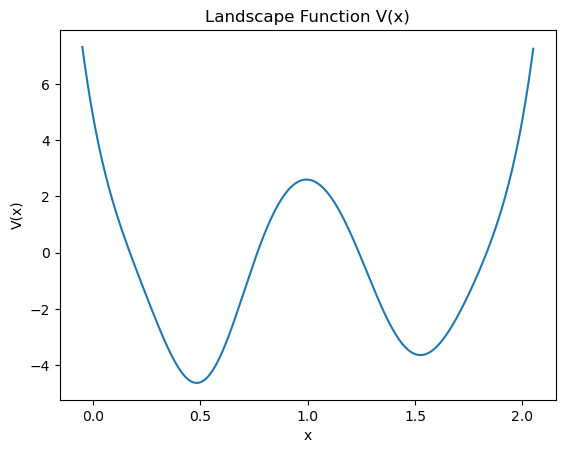

In [3]:
def two_well_1d(x, epsilon_0, epsilon_1, epsilon_2, sigma):
    """
    Defines the landscape function V(x) as described in the image.

    Args:
    x (float or numpy.ndarray): The independent variable.
    epsilon_0 (float): Parameter epsilon_0.
    epsilon_1 (float): Parameter epsilon_1.
    epsilon_2 (float): Parameter epsilon_2.
    sigma (float): Parameter sigma.

    Returns:
    float or numpy.ndarray: The value of the function V(x).
    """

    term1 = 5 * (x - 1)**8
    term2 = epsilon_0 * np.exp((-epsilon_0 * (x - 0.5)**2) / sigma**2)
    term3 = epsilon_1 * np.exp((-epsilon_1 * (x - 1.0)**2) / sigma**2)
    term4 = epsilon_2 * np.exp((-epsilon_2 * (x - 1.5)**2) / sigma**2)

    return term1 - term2 + term3 - term4

def plot_landscape_fxn(V: callable):
    """
    Plots the landscape function V(x) as described in the image.
    """

    x = np.linspace(-0.05, 2.05, 1000)
    y = V(x, epsilon_0, epsilon_1, epsilon_2, sigma)

    plt.plot(x, y)
    plt.xlabel('x')
    plt.ylabel('V(x)')
    plt.title('Landscape Function V(x)')
    plt.show()

plot_landscape_fxn(two_well_1d)

Define Multi-Well 1D Potential Function

In [4]:
def multi_well_potential(x, epsilon_0, epsilon_1, epsilon_2, sigma, base_power=8):
    """
    Defines a multi-well potential function V(x) with adjustable number of wells.

    Args:
    x (float or numpy.ndarray): The independent variable.
    epsilon_values (list): List of epsilon values for each well.
    well_positions (list): List of x-positions for each well.
    sigma (float): Parameter controlling the width of the wells.
    base_power (int): Power for the base polynomial term (default is 8).

    Returns:
    float or numpy.ndarray: The value of the function V(x).
    """
    
    well_positions = [0.25, 0.75, 1.5]
    epsilon_values = [epsilon_0, epsilon_1, epsilon_2]
    
    # Base polynomial term
    base_term = 5 * np.min([(x - pos)**base_power for pos in well_positions], axis=0)
    
    # Sum of Gaussian wells
    wells = sum(epsilon * np.exp((-epsilon * (x - pos)**2) / sigma**2) 
                for epsilon, pos in zip(epsilon_values, well_positions))
    
    return base_term - wells

## Defining Restoring Bias Functions

In [5]:
Nwindows = 100 # Number of windows, each of which corresponds to a bias function
min_x = -0.05
max_x = 2.05
dx = (max_x - min_x) / Nwindows

# Range of x values
x = np.linspace(min_x, max_x, Nwindows)

# Define bias functions for each window
bias: list[callable] = []

# Centers of each bias function
centers = np.linspace(min_x + dx/2, max_x - dx/2, Nwindows)

class PsiFunction:
    """
    Class to represent a harmonic bias function with a center and a spring constant.
    """
    
    def __init__(self, center, k):
        self.center = center
        self.k = k

    def __call__(self, x):
        return 0.5 * self.k * (x - self.center)**2

def create_biases(centers, k):
    return [PsiFunction(center, k) for center in centers]

# Create the bias functions
bias = create_biases(centers, k)

### Plot Restoring Bias Functions

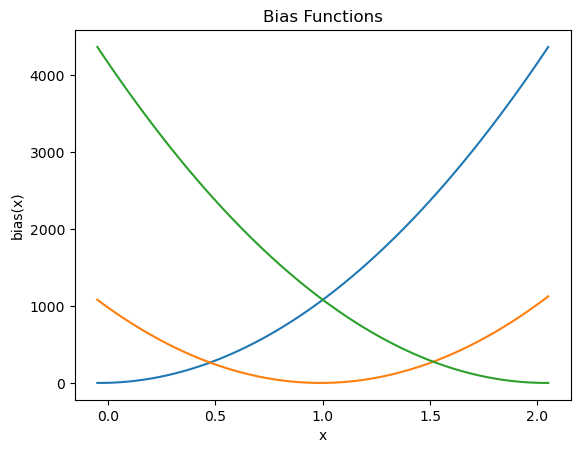

In [6]:
# Plot some bias functions

# Get the 1st, 50th, 99th bias functions
for psi in [bias[0], bias[49], bias[99]]:
    plt.plot(x, psi(x))

plt.xlabel('x')
plt.ylabel('bias(x)')
plt.title('Bias Functions')
plt.show()

# Monte-Carlo Sampling

Now, we actually implement the Monte-Carlo sampling algorithm to sample from the landscape potential function in the presence of a restoring bias function (which is essentially sampling from a window of the landscape potential function).

## Constants

In [7]:
T = 50 # K
kB = 1.38064852e-2 # Boltzmann constant (zJ/K)
beta = 1 / (kB * T)
printModulus = 10 # frequency of prints to screen
writeModulus = 10  # frequency of writes to file
dispSize = 0.05
nSweeps = 50_000 # number of MC sweeps

## Helper Functions

## Monte-Carlo Sampling Algorithm

In [8]:
samples = np.zeros((Nwindows, nSweeps))

def monte_carlo_sampling_per_window(args):
    """
    Perform Monte Carlo sampling of the biased distribution for a given window.

    Args:
    window_index (int): The index of the window.
    biases (callable): The list of bias functions for each window.
    V (callable): The landscape function V(x).

    Returns:
    numpy.ndarray: The samples drawn from the biased distribution.
    """

    # unpack the arguments
    window_index, biases, V = args

    # get the bias function for the window
    bias = biases[window_index]
    
    # define the range of x values for the window
    start_x = min_x + window_index * dx
    end_x = start_x + dx

    # pick a random starting point in the window and get potential energy
    current_x = np.random.uniform(start_x, end_x)
    current_U = V(current_x, epsilon_0, epsilon_1, epsilon_2, sigma) + bias(current_x)

    for sweep in range(nSweeps):
        # propose a new position
        proposed_x = current_x + dispSize * np.random.uniform(-1, 1)
        proposed_U = V(proposed_x, epsilon_0, epsilon_1, epsilon_2, sigma) + bias(proposed_x)

        # acceptance criterion
        delta_U = proposed_U - current_U
        acceptance_prob = min(0, -beta * delta_U)

        # accept or reject
        if np.log(np.random.uniform()) < acceptance_prob:
            current_x = proposed_x
            current_U = proposed_U

        samples[window_index, sweep] = current_x


def monte_carlo_sampling(biases, V):
    """
    Perform Monte Carlo sampling of the biased distribution.

    Args:
    biases (list[callable]): The list of bias functions for each window.
    V (callable): The landscape function V(x).

    Returns:
    numpy.ndarray: The samples drawn from the biased distribution.
    """
    for i in range(Nwindows):
        args = (i, biases, V)
        monte_carlo_sampling_per_window(args)

In [9]:
monte_carlo_sampling(bias, two_well_1d)

# Dump the samples to a file
np.savetxt('two_well_samples.txt', samples)

# Sample Analysis

In [10]:
samples = np.loadtxt('two_well_samples.txt')
samples.shape

(100, 50000)

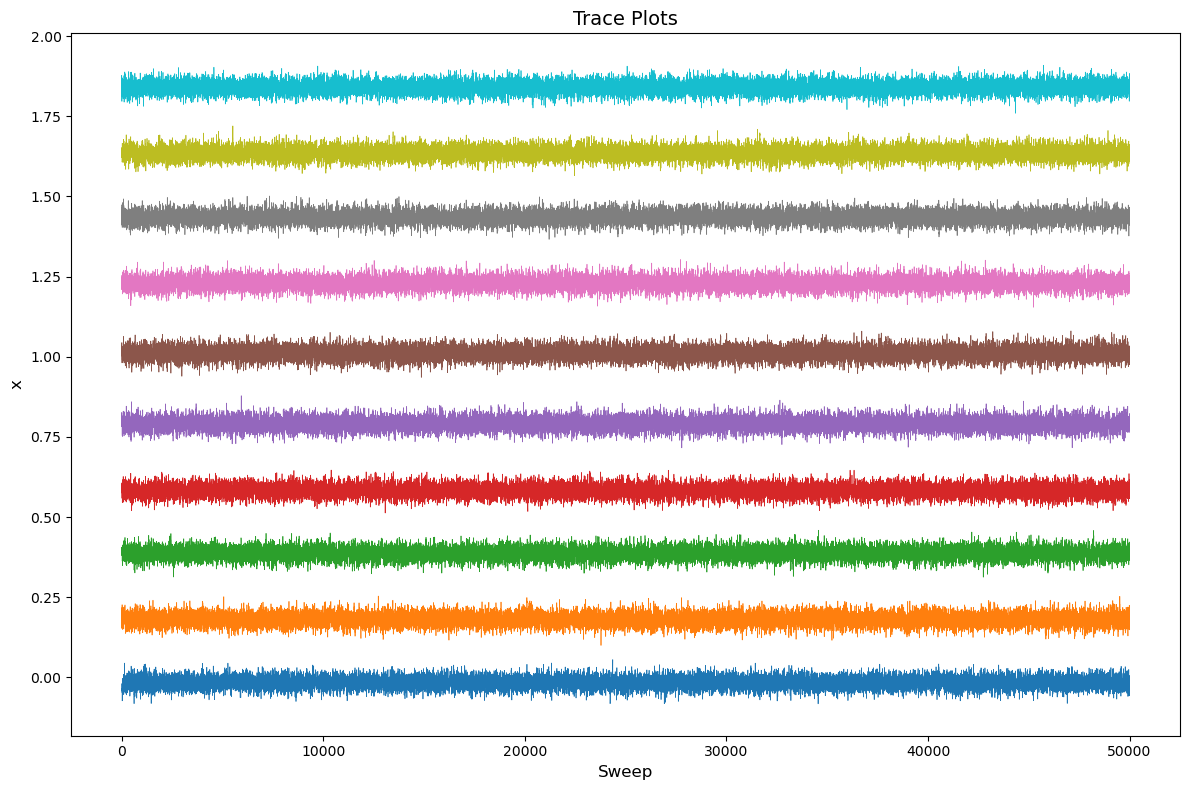

In [11]:
# Set the figure size to make the plot bigger
plt.figure(figsize=(12, 8))

# Plot the trace plots for every tenth window
for i in range(Nwindows):
    if i % 10 == 0:
        plt.plot(samples[i, :], linewidth=0.5) # Reduced linewidth for thinner lines

plt.xlabel('Sweep', fontsize=12)
plt.ylabel('x', fontsize=12)
plt.title('Trace Plots', fontsize=14)
plt.tick_params(axis='both', which='major', labelsize=10) # Adjust tick label size if needed

plt.tight_layout() # Adjust the layout to prevent clipping of labels
plt.show()


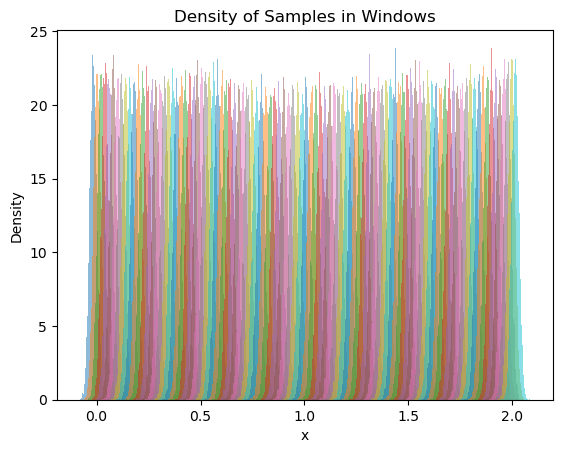

In [12]:
# Plot densities of the samples in all the windows
for i in range(Nwindows):
    plt.hist(samples[i], bins=50, density=True, alpha=0.5)

plt.xlabel('x')
plt.ylabel('Density')
plt.title('Density of Samples in Windows')
plt.show()

# WHAM
This contains our implementation of the weighted histogram analysis method in 1D, which takes the sampling data and reconstructs the probability distribution.

In [13]:
from scipy.interpolate import UnivariateSpline
import matplotlib.cm as cm
import matplotlib.colors as mcolors

def plot_normalized(P, bin_centers, color, bin_width):
    """
    Normalizes, then plots a probability distribution over a given set of bins.

    Args:
        P (np.ndarray): Probability distribution over bins
        bin_centers (np.ndarray): Centers of each bin the probability distribution is defined over
        color: Color to plot
        bin_width: Distance between bins
    
    Returns nothing, just creates a plot
    """
    P_AUC = np.sum(P) * bin_width
    P_normalized = P / P_AUC

    spline = UnivariateSpline(bin_centers, P_normalized, s=0.005)
    P_smooth = spline(bin_centers)

    plt.plot(bin_centers, P_smooth, '-', color=color)

def WHAM(samples, bias, V, plot=False, num_bins=100, max_iters=500, max_atol=1e-6):
    """
    Peforms the weighted histogram analysis method on a set of samples and bias functions.

    Args:
        samples (np.ndarray): Monte Carlo samples run with each bias function
        bias (list(PsiFunction)): List of bias functions used for simulation
        V (callable): True potential function
        plot (bool): Whether to plot iterations of the probability distribution
        num_bins (int): Number of bins to use within WHAM
        max_iters (int): Maximum number of iterations to run WHAM
        max_atol (float): Maximum difference between free energies between iterations before stopping
    
    Returns:
        P (np.ndarray): Final calculated probability distribution
        hists (np.ndarray): Histograms corresponding to each window
        bin_centers (np.ndarray): Centers of bins used within WHAM
        bin_edges (np.ndarray): Edges of bins used within WHAM
        global_free_energy (np.ndarray): Global free energy function over the WHAM bins
    """
    n = len(samples)

    # Create bins
    bin_edges = np.linspace(min_x, max_x, num_bins+1)
    bin_centers = (bin_edges[1:] + bin_edges[:-1]) / 2
    bin_width = bin_centers[-1] - bin_centers[-2]

    # Create histograms from samples
    hists = [np.histogram(samples[i,:], bins=bin_edges)[0] for i in range(n)] # bin counts

    # Number of samples within x range for each window
    n_ks = [np.sum(hists[k]) for k in range(n)]

    # Gather the biased probabilities
    P_tilde = np.array([hist_k / (bin_width * n_k) for hist_k, n_k in zip(hists, n_ks)])

    # Initialize free energies and probability function
    A = np.zeros(n)
    P = np.zeros(num_bins)
    A_0 = 0

    if plot:
        fig, ax = plt.subplots(figsize=(10, 6))
        cmap = cm.get_cmap('viridis', max_iters)

    for iter in range(max_iters):
        # Iteratively update P
        numerator = np.zeros(num_bins)
        denominator = np.zeros(num_bins)
        for k in range(n):
            numerator += P_tilde[k] * n_ks[k]

            denominator += n_ks[k] * np.exp(beta * (A[k] - A_0)) * np.exp(-beta * bias[k](bin_centers))
    
        P = numerator / denominator

        # Iteratively update the free energies
        max_free_energy_diff = 0

        for k in range(n):
            integral = bin_width * np.sum(P * np.exp(-beta * bias[k](bin_centers)))
            A_k_new = - np.log(integral) / beta + A_0
            
            max_free_energy_diff = max(max_free_energy_diff, abs(A_k_new - A[k]))
            A[k] = A_k_new
        
        # Normalize the probability distribution
        P /= np.sum(P) * bin_width

        if plot and iter % 5 == 0:
            color = cmap(iter / max_iters)  # Map iteration to a color in the colormap
            plot_normalized(P, bin_centers, color, bin_width)

        # Convergence criteria
        if max_free_energy_diff < max_atol:
            break

    if plot:
        norm = mcolors.Normalize(vmin=0, vmax=max_iters)
        sm = cm.ScalarMappable(cmap=cmap, norm=norm)
        sm.set_array([])  # Set an empty array to avoid warnings about missing data

        cbar = fig.colorbar(sm, ax=ax)  # Associate the colorbar with the main axes
        cbar.set_label('Iteration')

        plt.xlabel('x')
        plt.ylabel('P')
        plt.title('Constructing the Probability Distribution')

        # Plotting the true distribution
        recip_V = np.exp(-beta * V(bin_centers, epsilon_0, epsilon_1, epsilon_2, sigma))
        bin_width = (bin_centers[-1] - bin_centers[-2])
        norm_recip_V = recip_V/(np.sum(recip_V) * bin_width)
        plt.plot(bin_centers, norm_recip_V, color="red", linewidth=5, label="True")
        plt.gca().set_aspect('auto')
        plt.tight_layout()

        plt.show()
    
    # Return the global free energy function
    global_free_energy = -1/beta * np.log(P) + A_0
    
    return P, hists, bin_centers, bin_edges, global_free_energy

/var/folders/gf/rqrz_xpd00b34c0v2n9m1q1m0000gn/T/ipykernel_31949/1160027361.py:68: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  cmap = cm.get_cmap('viridis', max_iters)


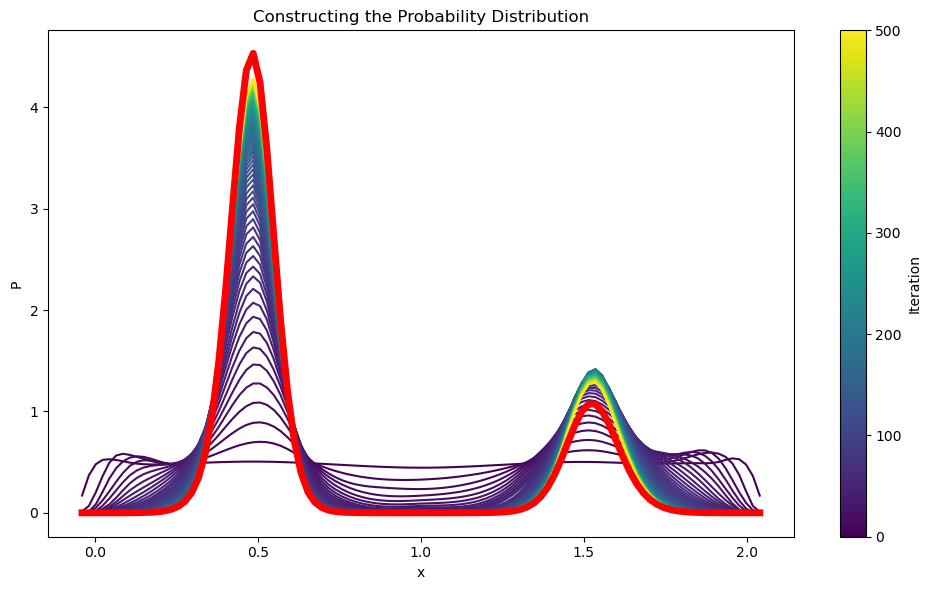

In [14]:
# Perform WHAM on the two well samples
P, hists, bin_centers, bin_edges, global_free_energy = WHAM(samples, bias, two_well_1d, plot=True, num_bins=100, max_iters=500, max_atol=1e-6)

In [15]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.interpolate import UnivariateSpline
from PIL import Image
import io

def WHAM_gif(samples, bias, V, num_bins=100, max_iters=500, max_atol=1e-6, prefix=""):
    """
    Performs WHAM while making a GIF showcasing the development of the probability distribution.
    """
    # Initial setup
    n = len(samples)
    bin_edges = np.linspace(min_x, max_x, num_bins+1)
    bin_centers = (bin_edges[1:] + bin_edges[:-1]) / 2
    bin_width = bin_centers[-1] - bin_centers[-2]
    hists = [np.histogram(samples[i,:], bins=bin_edges)[0] for i in range(n)]
    n_ks = [np.sum(hists[k]) for k in range(n)]
    P_tilde = np.array([hist_k / (bin_width * n_k) for hist_k, n_k in zip(hists, n_ks)])
    A = np.zeros(n)
    P = np.zeros(num_bins)
    A_0 = 0
    frames_prob = []
    frames_energy = []

    # Calculate the true distribution and energy
    recip_V = np.exp(-beta * V(bin_centers, epsilon_0, epsilon_1, epsilon_2, sigma))
    norm_recip_V = recip_V / (np.sum(recip_V) * bin_width)
    true_energy = V(bin_centers, epsilon_0, epsilon_1, epsilon_2, sigma)

    fig_prob, ax_prob = plt.subplots(figsize=(10, 6))
    fig_energy, ax_energy = plt.subplots(figsize=(10, 6))

    for iter in range(max_iters):
        numerator = np.zeros(num_bins)
        denominator = np.zeros(num_bins)
        for k in range(n):
            numerator += P_tilde[k] * n_ks[k]
            denominator += n_ks[k] * np.exp(beta * (A[k] - A_0)) * np.exp(-beta * bias[k](bin_centers))
        P = numerator / denominator

        max_free_energy_diff = 0
        for k in range(n):
            integral = np.sum(P * np.exp(-beta * bias[k](bin_centers))) * bin_width
            A_k_new = - np.log(integral) / beta + A_0
            max_free_energy_diff = max(max_free_energy_diff, abs(A_k_new - A[k]))
            A[k] = A_k_new
        
        P /= np.sum(P) * bin_width

        # Calculate energy
        energy = -1/beta * np.log(P)
        energy -= np.min(energy) - np.min(true_energy)  # Shift energy to start at 0

        # Plot and save probability frame
        plt.figure(fig_prob.number)
        plt.clf()
        P_AUC = np.sum(P) * bin_width
        P_normalized = P / P_AUC
        spline = UnivariateSpline(bin_centers, P_normalized, s=0.005)
        P_smooth = spline(bin_centers)
        plt.plot(bin_centers, P_smooth, '-', color='blue', label='Current P')
        plt.plot(bin_centers, norm_recip_V, color="red", linewidth=2, label="True")
        plt.xlabel('x')
        plt.ylabel('P')
        plt.title(f'Constructing the Probability Distribution')
        plt.ylim(0, max(np.max(P_normalized), np.max(norm_recip_V)) * 1.1)
        plt.tight_layout()

        buf = io.BytesIO()
        plt.savefig(buf, format='png')
        buf.seek(0)
        img = Image.open(buf)
        frames_prob.append(img)

        # Plot and save energy frame
        plt.figure(fig_energy.number)
        plt.clf()
        spline_E = UnivariateSpline(bin_centers, energy, s=0.05)
        E_smooth = spline_E(bin_centers)
        plt.plot(bin_centers, E_smooth, '-', color='blue', label='Current Energy')
        plt.plot(bin_centers, true_energy, color="red", linewidth=2, label="True Energy")
        plt.xlabel('x')
        plt.ylabel('Energy')
        plt.title(f'Constructing the Energy Landscape')
        plt.ylim(np.min(true_energy) * 1.1, np.max(true_energy) * 1.1)
        plt.tight_layout()

        buf = io.BytesIO()
        plt.savefig(buf, format='png')
        buf.seek(0)
        img = Image.open(buf)
        frames_energy.append(img)

        if max_free_energy_diff < max_atol:
            break
    
    # Save the full gifs
    frames_prob[0].save(f'{prefix}wham_probability_convergence.gif', save_all=True, append_images=frames_prob[1:], optimize=False, duration=20, loop=0)
    frames_energy[0].save(f'{prefix}wham_energy_convergence.gif', save_all=True, append_images=frames_energy[1:], optimize=False, duration=20, loop=0)
    
    return P, hists, bin_centers, bin_edges

(array([3.41648565e-07, 1.42556044e-06, 5.31915795e-06, 1.77826230e-05,
        5.10920544e-05, 1.28799541e-04, 3.07225296e-04, 6.63476299e-04,
        1.36742383e-03, 2.68644588e-03, 5.14504746e-03, 9.71902667e-03,
        1.81405245e-02, 3.29275787e-02, 5.91850030e-02, 1.09559683e-01,
        1.87807796e-01, 3.31412051e-01, 5.62325285e-01, 9.21703523e-01,
        1.42902854e+00, 2.09864237e+00, 2.84594826e+00, 3.59741405e+00,
        4.10356556e+00, 4.28674624e+00, 4.03968818e+00, 3.43129036e+00,
        2.57065456e+00, 1.78901916e+00, 1.12735723e+00, 6.67185356e-01,
        3.58055159e-01, 1.84254757e-01, 9.44346444e-02, 4.77669552e-02,
        2.37613844e-02, 1.17113740e-02, 5.88403609e-03, 3.10511998e-03,
        1.74210734e-03, 1.01505503e-03, 6.40813070e-04, 4.25485589e-04,
        2.90896684e-04, 2.16714618e-04, 1.69829365e-04, 1.43616482e-04,
        1.29805156e-04, 1.22227775e-04, 1.24899720e-04, 1.38381557e-04,
        1.57495106e-04, 1.94831568e-04, 2.60830242e-04, 3.582915

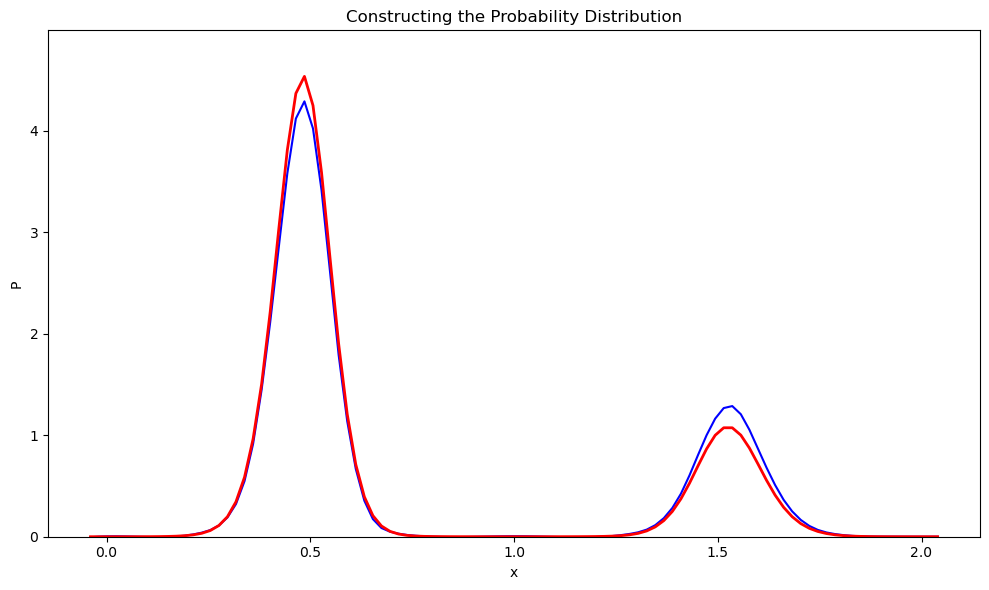

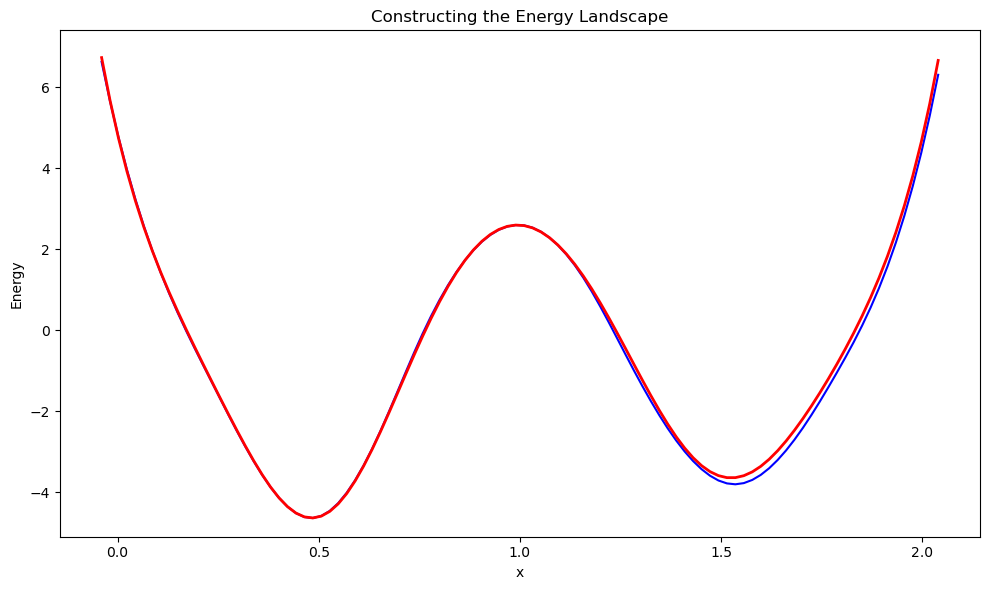

In [16]:
# Create the actual gif
WHAM_gif(samples, bias, two_well_1d, num_bins=100, max_iters=500, max_atol=1e-6, prefix="two_well_")

<!-- # Figure Generation -->

## Global Free Energy

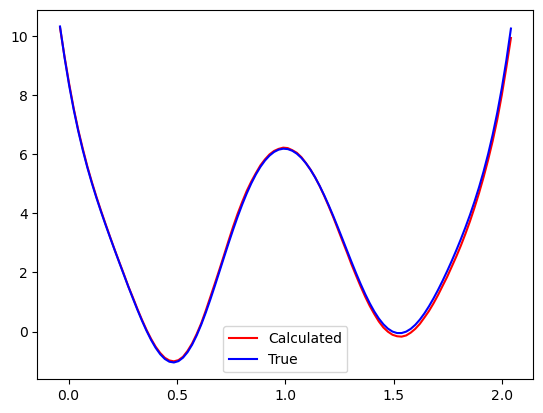

In [17]:
# Plot the true and calculated global free energy over the bins
plt.plot(bin_centers, global_free_energy, color='red', label='Calculated')

recip_V = np.exp(-beta * two_well_1d(bin_centers, epsilon_0, epsilon_1, epsilon_2, sigma))
bin_width = (bin_centers[-1] - bin_centers[-2])
norm_recip_V = recip_V/(np.sum(recip_V) * bin_width)
real_free_energy = -1/beta * np.log(norm_recip_V)

plt.plot(bin_centers, real_free_energy, color='blue', label='True')
plt.legend()

## Presentation Plots
A series of plots used within our [writeup](Writeup/writeup.pdf) and [presentation](https://www.youtube.com/watch?v=ezjPFCl8Q-8) are created in this section.

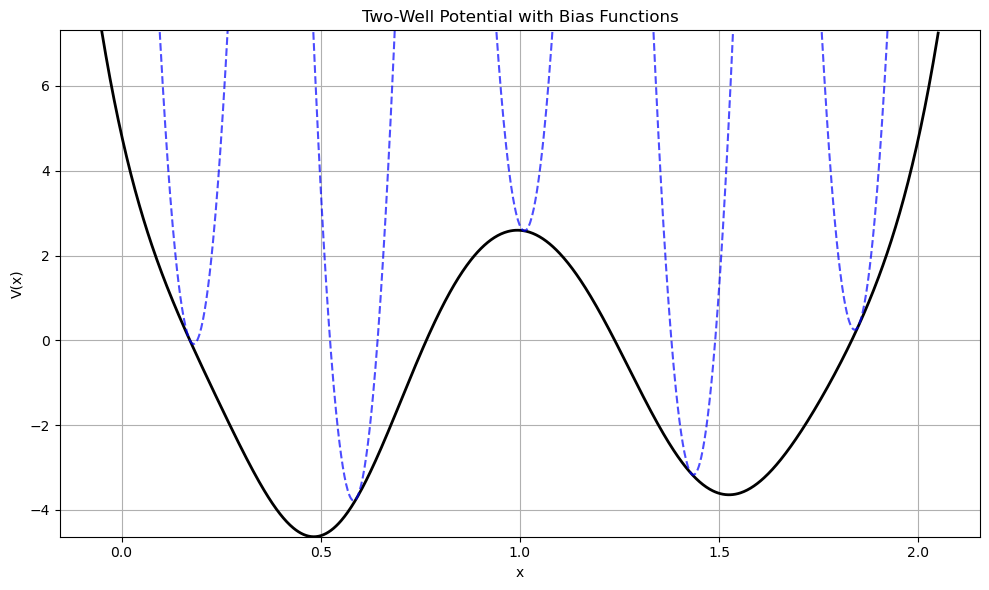

In [18]:
# Generate x values for plotting
x_vals = np.linspace(min_x, max_x, 1000)

# Plot the landscape function with bias functions overlaid
plt.figure(figsize=(10, 6))

# Plot the two-well potential function
y_vals_landscape = two_well_1d(x_vals, epsilon_0, epsilon_1, epsilon_2, sigma)
plt.plot(x_vals, y_vals_landscape, label='Two-Well Potential', color='black', linewidth=2)

# Overlay selected bias functions on top of the landscape function
for i in range(10, 100, 20):  # Plot bias functions from different windows
    y_vals_bias = bias[i](x_vals)
    
    # Mask to include only points where y_vals_bias <= 1
    mask = y_vals_bias <= 20
    
    combined_y_vals = y_vals_bias + y_vals_landscape
    plt.plot(x_vals[mask], combined_y_vals[mask], '--', color="blue", label=f'Bias Function {i+1}', alpha=0.7)

# Add labels and legend
plt.xlabel('x')
plt.ylabel('V(x)')
plt.title('Two-Well Potential with Bias Functions')
plt.ylim((np.min(y_vals_landscape), np.max(y_vals_landscape)))
plt.grid()
plt.gca().set_aspect('auto')
plt.tight_layout()
plt.show()

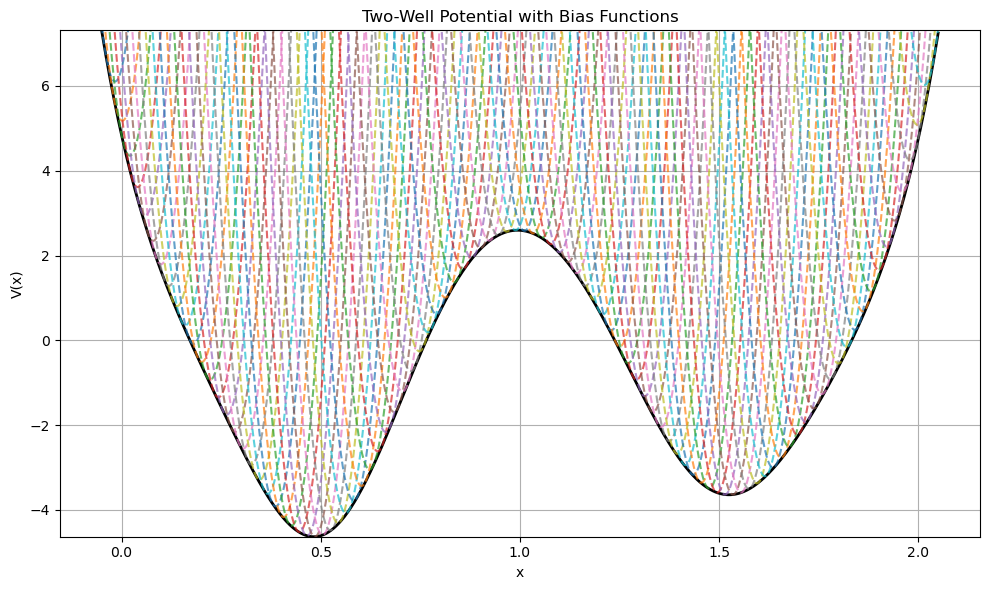

In [19]:
# Generate x values for plotting
x_vals = np.linspace(min_x, max_x, 1000)

# Plot the landscape function with bias functions overlaid
plt.figure(figsize=(10, 6))

# Plot the two-well potential function
y_vals_landscape = two_well_1d(x_vals, epsilon_0, epsilon_1, epsilon_2, sigma)
plt.plot(x_vals, y_vals_landscape, label='Two-Well Potential', color='black', linewidth=2)

# Overlay selected bias functions on top of the landscape function
for bias_i in bias:  # Plot bias functions from different windows
    y_vals_bias = bias_i(x_vals)
    
    combined_y_vals = y_vals_bias + y_vals_landscape
    plt.plot(x_vals, combined_y_vals, '--', label=f'Bias Function {i+1}', alpha=0.7)

# Add labels and legend
plt.xlabel('x')
plt.ylabel('V(x)')
plt.title('Two-Well Potential with Bias Functions')
plt.ylim((np.min(y_vals_landscape), np.max(y_vals_landscape)))
plt.grid()
plt.gca().set_aspect('auto')
plt.tight_layout()
plt.show()

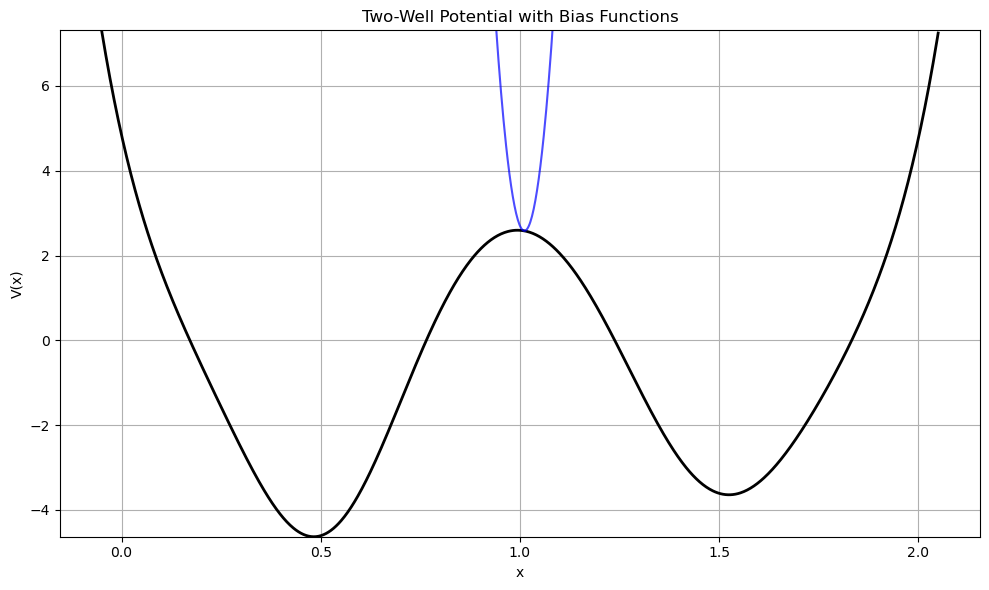

In [20]:
# Generate x values for plotting
x_vals = np.linspace(min_x, max_x, 1000)

# Plot the landscape function with bias functions overlaid
plt.figure(figsize=(10, 6))

# Plot the two-well potential function
y_vals_landscape = two_well_1d(x_vals, epsilon_0, epsilon_1, epsilon_2, sigma)
plt.plot(x_vals, y_vals_landscape, label='Two-Well Potential', color='black', linewidth=2)

# Overlay selected bias functions on top of the landscape function
i = len(bias)//2  # Plot bias functions from different windows
y_vals_bias = bias[i](x_vals)

# Mask to include only points where y_vals_bias <= 1
mask = y_vals_bias <= 20

combined_y_vals = y_vals_bias + y_vals_landscape
plt.plot(x_vals[mask], combined_y_vals[mask], color='blue', label=f'Bias Function {i+1}', alpha=0.7)

# Add labels and legend
plt.xlabel('x')
plt.ylabel('V(x)')
plt.title('Two-Well Potential with Bias Functions')
plt.ylim((np.min(y_vals_landscape), np.max(y_vals_landscape)))
plt.grid()
plt.gca().set_aspect('auto')
plt.tight_layout()
plt.show()

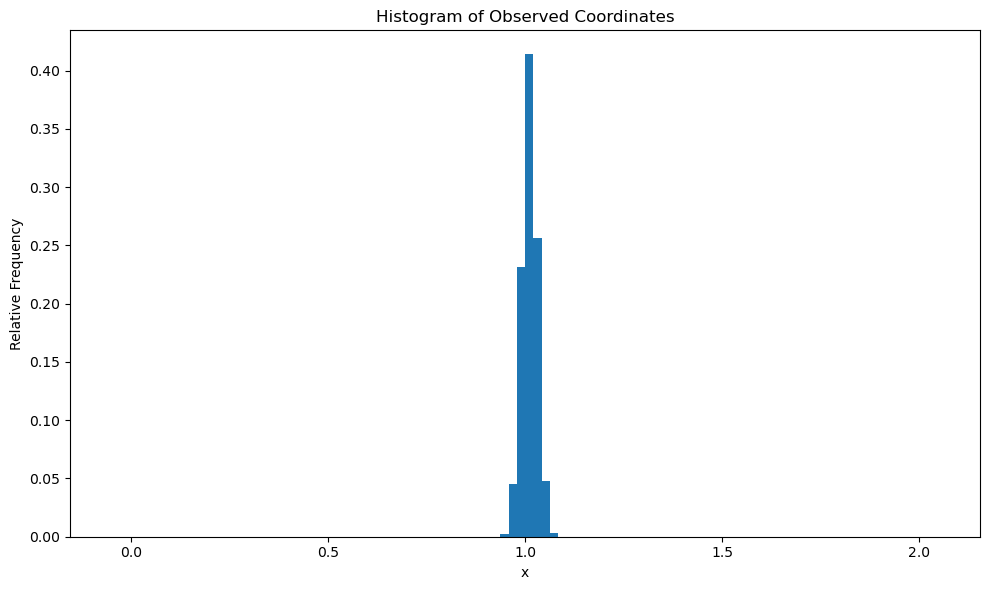

In [21]:
# Calculate bin width
width = bin_edges[1] - bin_edges[0]
hist_norm = hists[i] / np.sum(hists[i])

plt.figure(figsize=(10, 6))

# Plot the histogram
plt.bar(bin_edges[:-1], hist_norm, width=width, align='edge')

# Customize the plot
plt.xlabel('x')
plt.ylabel('Relative Frequency')
plt.title('Histogram of Observed Coordinates')

plt.gca().set_aspect('auto')
plt.tight_layout()
plt.show()

In [22]:
# Creating a GIF of the sample histograms

# Create a list to store the image frames
frames = []

# Calculate bin width
width = bin_edges[1] - bin_edges[0]

hists_norm = np.array([hists[i] / np.sum(hists[i]) for i in range(len(hists))])

for hist_norm in hists_norm:
    plt.figure(figsize=(10, 6))

    plt.bar(bin_edges[:-1], hist_norm, width=width, align='edge')
    plt.xlabel('x')
    plt.ylabel('Relative Frequency')
    plt.title(f'Histogram of Observed Coordinates')
    plt.ylim((np.min(hists_norm), np.max(hists_norm)))

    plt.gca().set_aspect('auto')
    plt.tight_layout()

    # Save the plot to a bytes buffer
    buf = io.BytesIO()
    plt.savefig(buf, format='png')
    buf.seek(0)

    # Create an image from the buffer and append to frames
    img = Image.open(buf)
    frames.append(img)

    plt.close()  # Close the figure to free up memory

# Save the frames as an animated GIF
frames[0].save('histogram_animation.gif', save_all=True, append_images=frames[1:], optimize=False, duration=20, loop=0)

In [23]:
# Create a gif of the bias function moving across the potential landscape

frames = []

# Generate x values for plotting
x_vals = np.linspace(min_x, max_x, 1000)

# Loop through bias functions to create frames
for i in range(len(bias)):
    plt.figure(figsize=(10, 6))

    # Plot the two-well potential function
    y_vals_landscape = two_well_1d(x_vals, epsilon_0, epsilon_1, epsilon_2, sigma)
    plt.plot(x_vals, y_vals_landscape, label='Two-Well Potential', color='black', linewidth=2)

    # Overlay selected bias functions on top of the landscape function
    y_vals_bias = bias[i](x_vals)

    # Mask to include only points where y_vals_bias <= 20
    mask = y_vals_bias <= 20
    combined_y_vals = y_vals_bias + y_vals_landscape

    plt.plot(x_vals[mask], combined_y_vals[mask], color='blue', label=f'Bias Function {i+1}', alpha=0.7)

    # Add labels and legend
    plt.xlabel('x')
    plt.ylabel('V(x)')
    plt.title(f'Two-Well Potential with Bias Functions')
    plt.ylim((np.min(y_vals_landscape), np.max(y_vals_landscape)))
    plt.grid()
    plt.tight_layout()

    # Save the plot to a bytes buffer
    buf = io.BytesIO()
    plt.savefig(buf, format='png')
    buf.seek(0)

    # Create an image from the buffer and append to frames
    img = Image.open(buf)
    frames.append(img)

    plt.close()  # Close the figure to free up memory

# Save the frames as an animated GIF
frames[0].save('two_well_potential_animation.gif', save_all=True, append_images=frames[1:], optimize=False, duration=20, loop=0)

# Multi Well
In this section, we perform our simulation on a multi-well potential.

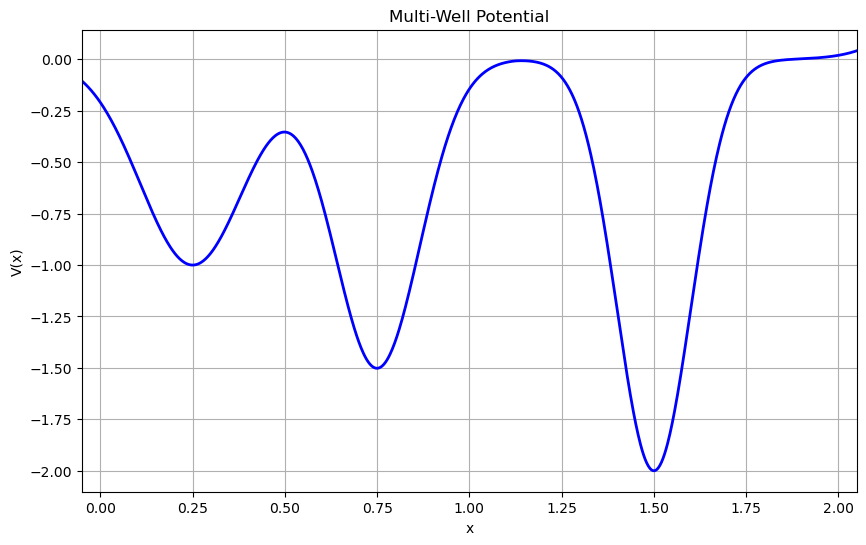

In [24]:
## Parameters for Two Well 1-D Potential

epsilon_0 = 1.0
epsilon_1 = 1.5
epsilon_2 = 2
sigma = 0.2

# Generate x values for the new domain
x = np.linspace(-0.05, 2.05, 1000)

# Calculate potential
V = multi_well_potential(x, epsilon_0, epsilon_1, epsilon_2, sigma)

# Plot
plt.figure(figsize=(10, 6))
plt.plot(x, V, 'b-', linewidth=2)
plt.title('Multi-Well Potential')
plt.xlabel('x')
plt.ylabel('V(x)')
plt.xlim(-0.05, 2.05)  # Set x-axis limits
plt.grid(True)

plt.show()

In [25]:
samples = np.zeros((Nwindows, nSweeps))
monte_carlo_sampling(bias, multi_well_potential)

np.savetxt('multi_well_samples.txt', samples)

/var/folders/gf/rqrz_xpd00b34c0v2n9m1q1m0000gn/T/ipykernel_31949/1160027361.py:68: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  cmap = cm.get_cmap('viridis', max_iters)


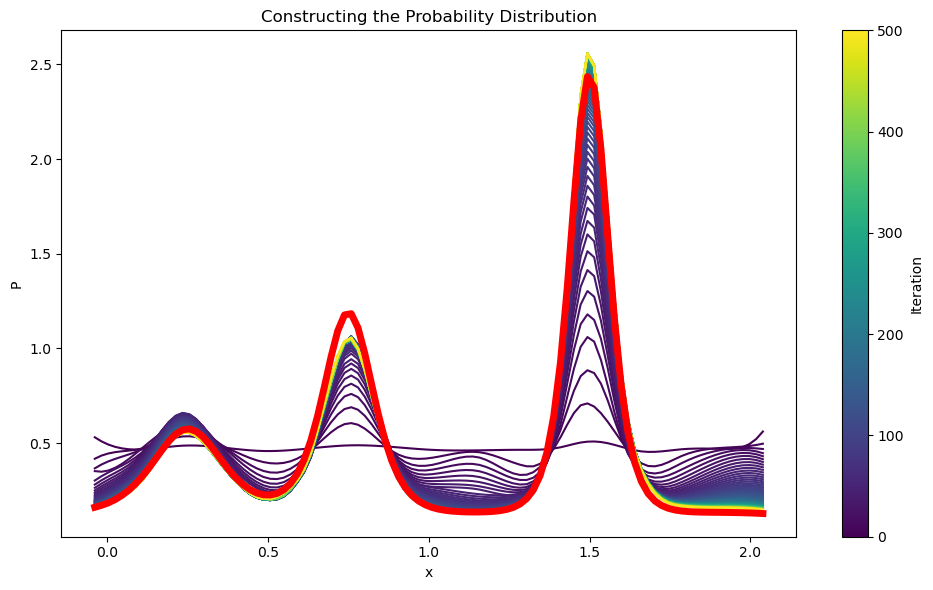

In [26]:
P, hists, bin_centers, bin_edges, global_free_energy = WHAM(samples, bias, multi_well_potential, plot=True, num_bins=100, max_iters=500, max_atol=1e-6)

(array([0.152586  , 0.16508149, 0.17996637, 0.196703  , 0.21454454,
        0.23908297, 0.26916748, 0.3083347 , 0.35307341, 0.4041046 ,
        0.44769823, 0.49146702, 0.51768144, 0.5598711 , 0.55962392,
        0.54252684, 0.52305564, 0.47867016, 0.416168  , 0.37502801,
        0.32860521, 0.29724486, 0.26184428, 0.24071256, 0.22226689,
        0.20920764, 0.20557012, 0.21318337, 0.23614883, 0.26105323,
        0.30688389, 0.37512501, 0.45815563, 0.56743532, 0.69876673,
        0.83166962, 0.97140277, 1.02935886, 1.06190584, 1.01617712,
        0.89668478, 0.75653425, 0.60992417, 0.49493128, 0.38867511,
        0.31030403, 0.2575484 , 0.21264683, 0.18463707, 0.16896724,
        0.15483298, 0.14684033, 0.14204826, 0.13666036, 0.13487092,
        0.13461119, 0.13508427, 0.13405406, 0.13623792, 0.13826279,
        0.14053804, 0.15010626, 0.15830933, 0.1798126 , 0.20838992,
        0.25743278, 0.33407359, 0.46085335, 0.67678334, 0.97684472,
        1.37842146, 1.90556488, 2.31791833, 2.57

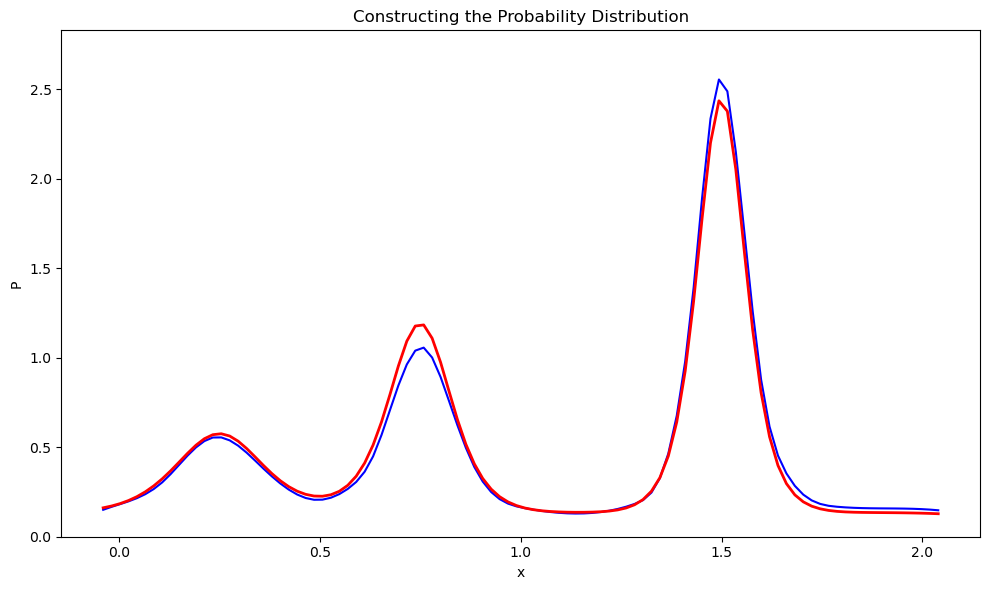

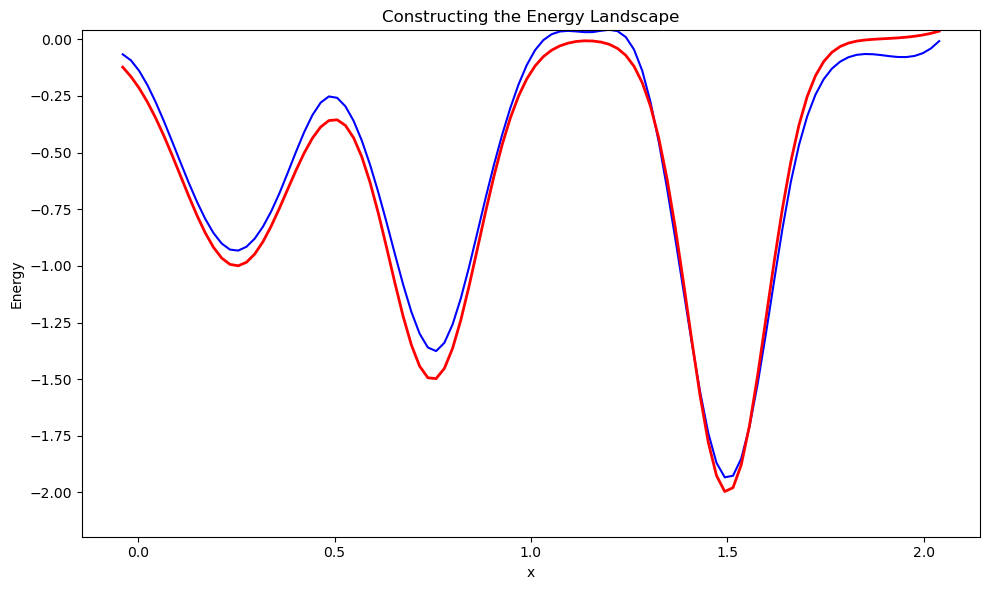

In [27]:
WHAM_gif(samples, bias, multi_well_potential, num_bins=100, max_iters=500, max_atol=1e-6, prefix="multi_well_")